In [1]:
import h5py
import logging

import numpy as np
import matplotlib.pyplot as plt

from scipy import signal, interpolate


In [2]:
logging.basicConfig(level = logging.DEBUG)
log = logging.getLogger(__name__)

In [4]:
def get_output_data(filename, rxnumber, rxcomponent):
    """Gets B-scan output data from a model.
    Args:
        filename (string): Filename (including path) of output file.
        rxnumber (int): Receiver output number.
        rxcomponent (str): Receiver output field/current component.
    Returns:
        outputdata (array): Array of A-scans, i.e. B-scan data.
        dt (float): Temporal resolution of the model.
    """

    # Open output file and read some attributes
    f = h5py.File(filename, 'r')
    nrx = f.attrs['nrx']
    dt = f.attrs['dt']

    # Check there are any receivers
    if nrx == 0:
        raise Exception('No receivers found in {}'.format(filename))

    path = '/rxs/rx' + str(rxnumber) + '/'
    availableoutputs = list(f[path].keys())

    # Check if requested output is in file
    if rxcomponent not in availableoutputs:
        raise Exception('{} output requested to plot, but the available output for receiver 1 is {}'.format(rxcomponent, ', '.join(availableoutputs)))

    outputdata = f[path + '/' + rxcomponent]
    outputdata = np.array(outputdata)
    f.close()

    return outputdata, dt

In [4]:
def read_c_scan(filename: str, polarization: str = 'x'):
    """
    Reads a .h5 file with a time domain C-Scan and returns it as a ndarray along with its axis.
    :param filename:
    :param polarization:
    :return:
    """

    if polarization not in ['x', 'y']:
        raise ValueError(f"Value {polarization} not valid. Should be : x or y")

    data_frame = h5py.File(filename, 'r')

    t0 = data_frame['Time'].attrs['t0']
    tf = data_frame['Time'].attrs['tf']
    qt = int(data_frame['Time'].attrs['q'])
    # x- and y-axis lower limits, upper limits and step are retrieved
    x0 = data_frame['Position'].attrs['x0']
    dx = data_frame['Position'].attrs['dx']
    xf = data_frame['Position'].attrs['xf']
    y0 = data_frame['Position'].attrs['y0']
    dy = data_frame['Position'].attrs['dy']
    yf = data_frame['Position'].attrs['yf']

    # Amount of steps over each axis is calculated. Operation rounds up the division result as needed
    qx = int(round((xf - x0) / dx + 1))
    qy = int(round((yf - y0) / dy + 1))

    # Axis ndarray created
    x = np.linspace(x0, xf, qx)
    y = np.linspace(y0, yf, qy)
    t = np.linspace(t0, tf, qt)

    c_scan = np.zeros((qx, qy, qt), dtype = np.cfloat)

    for i in range(0, qx):
        # Indexes used to retrieve individual planes of the C-Scan are calculated
        index_0 = i * qy
        index_f = (i + 1) * qy
        c_scan[i, :, :] = data_frame[f'A-Scan/Re{{A-Scan {polarization}-pol}}'][index_0:index_f][:] + 1j*data_frame[f'A-Scan/Im{{A-Scan {polarization}-pol}}'][index_0:index_f][:]

    return c_scan, x, y, t

In [4]:
c_scan, x, y, t = read_c_scan(r"C:\Users\leone\OneDrive - Universidad de los Andes\Universidad\Proyecto Desminado\Machine Learning\Nuevas mediciones\Time\C_scan_default_title_0_125_new.h5", 'x')

c_scan_mag = np.abs(c_scan)

plt.plot(t[:141], c_scan[71, 71, :141])

NameError: name 'read_c_scan' is not defined

In [169]:
def permittivity_estimation(a_scan: np.ndarray, t: np.ndarray, antenna_offset: float, ):
    peaks, _ = signal.find_peaks(a_scan*np.exp(1.2e8*t), distance=10, prominence=(np.amax(a_scan)-0.5*np.std(a_scan), None))
    plt.plot(t, a_scan*np.exp(1.2e8*t))
    plt.plot(t[peaks], a_scan[peaks]*np.exp(1.25e8*t[peaks]), "x")
    t_dw = t[peaks[0]]
    t_gw = t[peaks[1]]
    c = 3e8
    e_r = ((c*(t_gw-t_dw)/antenna_offset)-2*(0.4+0.18)/antenna_offset)**2

    t_bi = t[peaks[2]]
    d = 0.5*(t_bi-t_gw)*c/np.sqrt(e_r)
    return e_r, d



(2.5313847619328955, 0.48775668396505256)

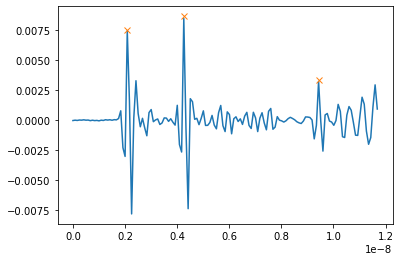

In [170]:
permittivity_estimation(c_scan[35, 71, :141], t[:141], 0.32)

C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


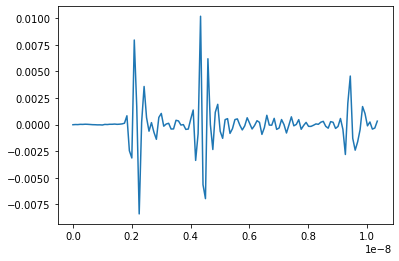

In [49]:
plt.plot(t[:125], c_scan[0, 0, :125]*np.exp(1.5e8*t[:125]))

In [5]:
def traces_cross_correlation(traces: np.ndarray, offset: np.ndarray, time: np.ndarray, velocity: np.ndarray):

    n_offset = offset.size
    z = velocity[np.newaxis, :]*time[:, np.newaxis]/2
    t_z = np.sqrt(offset[:, np.newaxis, np.newaxis]**2 + 4*z[np.newaxis, :, :]**2)/velocity[np.newaxis, np.newaxis, :]
    print(f"t_z shape: {t_z.shape}")
    f = interpolate.interp1d(time, signal.hilbert(traces), kind = 'linear', axis = -1, fill_value = 'extrapolate')
    f = f(t_z)

    cross_correlation = np.zeros((time.size, velocity.size))

    for v_idx, v in enumerate(velocity):
        for tau_idx, tau in enumerate(time):
            cc = 0
            for i in range(n_offset-1):
                for j in range(i, n_offset):
                    cc+= np.real(f[i, i, tau_idx, v_idx])*np.real(f[j, j, tau_idx, v_idx]) + np.imag(f[i, i, tau_idx, v_idx])*np.imag(f[j, j, tau_idx, v_idx])

            cross_correlation[tau_idx, v_idx] = cc

    return cross_correlation

In [6]:
from sklearn.cluster import DBSCAN

def permittivity_estimation(cross_correlation: np.ndarray, t: np.ndarray, velocity: np.ndarray):

    th = np.quantile(cross_correlation, 0.90)
    th_idx = np.where(cross_correlation >= th)

    X = np.column_stack((th_idx[0], th_idx[1]))
    dbscan = DBSCAN(eps=2, min_samples=10).fit(X)

    n_clusters = np.max(dbscan.labels_)+1
    print(f"Number of clusters found: {n_clusters}")
    max_cc_idx  = np.zeros((n_clusters, 2), dtype = int)
    for i in range(n_clusters):
        cluster_idx = X[dbscan.labels_ == i]
        max_cluster_cc_idx = np.where(cross_correlation == np.amax(cross_correlation[cluster_idx[:, 0], cluster_idx[:, 1]]))
        max_cc_idx[i, :] = np.array([max_cluster_cc_idx[0][0], max_cluster_cc_idx[1][0]])

    max_cc_idx = max_cc_idx[max_cc_idx[:, 0].argsort()]

    t_1, v_1 = t[max_cc_idx[1, 0]], velocity[max_cc_idx[1, 1]]
    t_2, v_2 = t[max_cc_idx[2, 0]], velocity[max_cc_idx[2, 1]]
    print(f"First picked time {t_1*1e9:.4f} ns, and picked velocity: {v_1*1e-9:.4f} m/ns")
    print(f"Second picked time {t_2*1e9:.4f} ns, and picked velocity: {v_2*1e-9:.4f} m/ns")
    v_int = np.sqrt((v_2**2 * t_2 - v_1**2 * t_1)/(t_2-t_1))

    e_r_1, z_1 = (3e8/v_1)**2, v_1*t_1/2
    e_r_2, z_2 = (3e8/v_int)**2, v_int*(t_2 - t_1)/2

    permittivities = np.array([e_r_1, e_r_2])
    thicknesses = np.array([z_1, z_2])

    return permittivities, thicknesses

In [26]:
c_scan, dt = get_output_data("antenna_offset_merged.out", 1, "Ez")
t = np.arange(0, 14e-9+dt/2, dt)
c_scan.shape

(2969, 20)

In [13]:
#c_scan, x, y, t = read_c_scan(r"C:\Users\leone\OneDrive - Universidad de los Andes\Universidad\Proyecto Desminado\Machine Learning\Nuevas mediciones\Time\C_scan_default_title_0_125_new.h5", 'x')

c_scan, dt = get_output_data("antenna_offset_merged.out", 1, "Ez")
t = np.arange(0, 14e-9+dt/2, dt)
res_c_scan, res_t = signal.resample(c_scan, 250, t, axis=0)
print(res_c_scan.shape)
res_c_scan = np.swapaxes(res_c_scan, 0, 1)
offset = np.linspace(0.10, 0.48, 20)


velocity = np.linspace(0.05e9, 0.35e9, num = 250)

cross_correlation = traces_cross_correlation(np.real(res_c_scan), offset, res_t, velocity)
est_permittivities, est_thicknesses = permittivity_estimation(cross_correlation, res_t, velocity)

true_permittivities, true_thicknesses = np.array([2, 4.5]), np.array([0.2, 0.4])

permittivity_error = np.abs(est_permittivities - true_permittivities)/true_permittivities
thicknesses_error = np.abs(est_thicknesses - true_thicknesses)/true_thicknesses


print()
print("Layer 1")
print(f"True permittivity is {true_permittivities[0]:.2f}, estimated was {est_permittivities[0]:.2f}. Error: {permittivity_error[0]:.2%}")
print(f"True thickness is {true_thicknesses[0]:.2f}, estimated was {est_thicknesses[0]:.2f}. Error: {thicknesses_error[0]:.2%}")
print()
print("Layer 2")
print(f"True permittivity is {true_permittivities[1]:.2f}, estimated was {est_permittivities[1]:.2f}. Error: {permittivity_error[1]:.2%}")
print(f"True thickness is {true_thicknesses[1]:.2f}, estimated was {est_thicknesses[1]:.2f}. Error: {thicknesses_error[1]:.2%}")

(250, 20)
t_z shape: (20, 250, 250)
Number of clusters found: 3
First picked time 2.8572 ns, and picked velocity: 0.1825 m/ns
Second picked time 8.5155 ns, and picked velocity: 0.1536 m/ns

Layer 1
True permittivity is 2.00, estimated was 2.70. Error: 35.07%
True thickness is 0.20, estimated was 0.26. Error: 30.38%

Layer 2
True permittivity is 4.50, estimated was 4.82. Error: 7.01%
True thickness is 0.40, estimated was 0.39. Error: 3.31%


In [11]:
c_scan, dt = get_output_data("antenna_offset_merged.out", 1, "Ez")
t = np.arange(0, 14e-9+dt/2, dt)
res_c_scan, res_t = signal.resample(c_scan, 500, t, axis=0)
print(res_c_scan.shape)
res_c_scan = np.swapaxes(res_c_scan, 0, 1)
offset = np.linspace(0.10, 0.48, 20)


velocity = np.linspace(0.05e9, 0.35e9, num = 500)

cross_correlation = traces_cross_correlation(np.real(res_c_scan), offset, res_t, velocity)
est_permittivities, est_thicknesses = permittivity_estimation(cross_correlation, res_t, velocity)

true_permittivities, true_thicknesses = np.array([2, 4.5]), np.array([0.2, 0.4])

permittivity_error = np.abs(est_permittivities - true_permittivities)/true_permittivities
thicknesses_error = np.abs(est_thicknesses - true_thicknesses)/true_thicknesses


print()
print("Layer 1")
print(f"True permittivity is {true_permittivities[0]:.2f}, estimated was {est_permittivities[0]:.2f}. Error: {permittivity_error[0]:.2%}")
print(f"True thickness is {true_thicknesses[0]:.2f}, estimated was {est_thicknesses[0]:.2f}. Error: {thicknesses_error[0]:.2%}")
print()
print("Layer 2")
print(f"True permittivity is {true_permittivities[1]:.2f}, estimated was {est_permittivities[1]:.2f}. Error: {permittivity_error[1]:.2%}")
print(f"True thickness is {true_thicknesses[1]:.2f}, estimated was {est_thicknesses[1]:.2f}. Error: {thicknesses_error[1]:.2%}")

(500, 20)
t_z shape: (20, 500, 500)
Number of clusters found: 3
First picked time 2.8572 ns, and picked velocity: 0.1811 m/ns
Second picked time 8.5155 ns, and picked velocity: 0.1528 m/ns

Layer 1
True permittivity is 2.00, estimated was 2.75. Error: 37.26%
True thickness is 0.20, estimated was 0.26. Error: 29.33%

Layer 2
True permittivity is 4.50, estimated was 4.84. Error: 7.61%
True thickness is 0.40, estimated was 0.39. Error: 3.58%


In [14]:
c_scan, dt = get_output_data("antenna_offset_v2_merged.out", 1, "Ez")
t = np.arange(0, 14e-9+dt/2, dt)
res_c_scan, res_t = signal.resample(c_scan, 250, t, axis=0)
print(res_c_scan.shape)
res_c_scan = np.swapaxes(res_c_scan, 0, 1)
offset = np.linspace(0.10, 0.48, 20)


velocity = np.linspace(0.05e9, 0.35e9, num = 250)

cross_correlation = traces_cross_correlation(np.real(res_c_scan), offset, res_t, velocity)
est_permittivities, est_thicknesses = permittivity_estimation(cross_correlation, res_t, velocity)

true_permittivities, true_thicknesses = np.array([2, 4.5]), np.array([0.2, 0.2])

permittivity_error = np.abs(est_permittivities - true_permittivities)/true_permittivities
thicknesses_error = np.abs(est_thicknesses - true_thicknesses)/true_thicknesses


print()
print("Layer 1")
print(f"True permittivity is {true_permittivities[0]:.2f}, estimated was {est_permittivities[0]:.2f}. Error: {permittivity_error[0]:.2%}")
print(f"True thickness is {true_thicknesses[0]:.2f}, estimated was {est_thicknesses[0]:.2f}. Error: {thicknesses_error[0]:.2%}")
print()
print("Layer 2")
print(f"True permittivity is {true_permittivities[1]:.2f}, estimated was {est_permittivities[1]:.2f}. Error: {permittivity_error[1]:.2%}")
print(f"True thickness is {true_thicknesses[1]:.2f}, estimated was {est_thicknesses[1]:.2f}. Error: {thicknesses_error[1]:.2%}")

(250, 20)
t_z shape: (20, 250, 250)
Number of clusters found: 3
First picked time 2.8572 ns, and picked velocity: 0.1825 m/ns
Second picked time 5.6583 ns, and picked velocity: 0.1620 m/ns

Layer 1
True permittivity is 2.00, estimated was 2.70. Error: 35.07%
True thickness is 0.20, estimated was 0.26. Error: 30.38%

Layer 2
True permittivity is 4.50, estimated was 4.72. Error: 4.93%
True thickness is 0.20, estimated was 0.19. Error: 3.32%


In [55]:
c_scan, dt = get_output_data("antenna_offset_v3_merged.out", 1, "Ez")
t = np.arange(0, 14e-9+dt/2, dt)
res_c_scan, res_t = signal.resample(c_scan, 250, t, axis=0)
print(res_c_scan.shape)
res_c_scan = np.swapaxes(res_c_scan, 0, 1)
offset = np.linspace(0.10, 0.48, 20)


velocity = np.linspace(0.05e9, 0.35e9, num = 250)

cross_correlation = traces_cross_correlation(np.real(res_c_scan), offset, res_t, velocity)
est_permittivities, est_thicknesses = permittivity_estimation(cross_correlation, res_t, velocity)

true_permittivities, true_thicknesses = np.array([2, 4.5]), np.array([0.4, 0.2])

permittivity_error = np.abs(est_permittivities - true_permittivities)/true_permittivities
thicknesses_error = np.abs(est_thicknesses - true_thicknesses)/true_thicknesses


print()
print("Layer 1")
print(f"True permittivity is {true_permittivities[0]:.2f}, estimated was {est_permittivities[0]:.2f}. Error: {permittivity_error[0]:.2%}")
print(f"True thickness is {true_thicknesses[0]:.2f}, estimated was {est_thicknesses[0]:.2f}. Error: {thicknesses_error[0]:.2%}")
print()
print("Layer 2")
print(f"True permittivity is {true_permittivities[1]:.2f}, estimated was {est_permittivities[1]:.2f}. Error: {permittivity_error[1]:.2%}")
print(f"True thickness is {true_thicknesses[1]:.2f}, estimated was {est_thicknesses[1]:.2f}. Error: {thicknesses_error[1]:.2%}")


(250, 20)
t_z shape: (20, 250, 250)
Number of clusters found: 3
First picked time 4.7619 ns, and picked velocity: 0.1934 m/ns
Second picked time 7.5631 ns, and picked velocity: 0.1741 m/ns

Layer 1
True permittivity is 2.00, estimated was 2.41. Error: 20.34%
True thickness is 0.40, estimated was 0.46. Error: 15.10%

Layer 2
True permittivity is 4.50, estimated was 4.93. Error: 9.49%
True thickness is 0.20, estimated was 0.19. Error: 5.35%


In [65]:
c_scan, dt = get_output_data("antenna_offset_v4_merged.out", 1, "Ez")
t = np.arange(0, 14e-9+dt/2, dt)
res_c_scan, res_t = signal.resample(c_scan, 250, t, axis=0)
print(res_c_scan.shape)
res_c_scan = np.swapaxes(res_c_scan, 0, 1)
offset = np.linspace(0.10, 0.48, 20)


velocity = np.linspace(0.05e9, 0.35e9, num = 250)

cross_correlation = traces_cross_correlation(np.real(res_c_scan), offset, res_t, velocity)
est_permittivities, est_thicknesses = permittivity_estimation(cross_correlation, res_t, velocity)

true_permittivities, true_thicknesses = np.array([4, 2]), np.array([0.3, 0.3])

permittivity_error = np.abs(est_permittivities - true_permittivities)/true_permittivities
thicknesses_error = np.abs(est_thicknesses - true_thicknesses)/true_thicknesses


print()
print("Layer 1")
print(f"True permittivity is {true_permittivities[0]:.2f}, estimated was {est_permittivities[0]:.2f}. Error: {permittivity_error[0]:.2%}")
print(f"True thickness is {true_thicknesses[0]:.2f}, estimated was {est_thicknesses[0]:.2f}. Error: {thicknesses_error[0]:.2%}")
print()
print("Layer 2")
print(f"True permittivity is {true_permittivities[1]:.2f}, estimated was {est_permittivities[1]:.2f}. Error: {permittivity_error[1]:.2%}")
print(f"True thickness is {true_thicknesses[1]:.2f}, estimated was {est_thicknesses[1]:.2f}. Error: {thicknesses_error[1]:.2%}")

(250, 20)
t_z shape: (20, 250, 250)
Number of clusters found: 3
First picked time 3.6975 ns, and picked velocity: 0.1392 m/ns
Second picked time 6.4426 ns, and picked velocity: 0.1717 m/ns

Layer 1
True permittivity is 4.00, estimated was 4.65. Error: 16.19%
True thickness is 0.30, estimated was 0.26. Error: 14.24%

Layer 2
True permittivity is 2.00, estimated was 2.09. Error: 4.42%
True thickness is 0.30, estimated was 0.28. Error: 5.02%


In [61]:
c_scan, dt = get_output_data("antenna_offset_v5_merged.out", 1, "Ez")
t = np.arange(0, 14e-9+dt/2, dt)
res_c_scan, res_t = signal.resample(c_scan, 250, t, axis=0)
print(res_c_scan.shape)
res_c_scan = np.swapaxes(res_c_scan, 0, 1)
offset = np.linspace(0.10, 0.48, 20)


velocity = np.linspace(0.05e9, 0.35e9, num = 250)

cross_correlation = traces_cross_correlation(np.real(res_c_scan), offset, res_t, velocity)
est_permittivities, est_thicknesses = permittivity_estimation(cross_correlation, res_t, velocity)

true_permittivities, true_thicknesses = np.array([2, 6]), np.array([0.3, 0.3])

permittivity_error = np.abs(est_permittivities - true_permittivities)/true_permittivities
thicknesses_error = np.abs(est_thicknesses - true_thicknesses)/true_thicknesses


print()
print("Layer 1")
print(f"True permittivity is {true_permittivities[0]:.2f}, estimated was {est_permittivities[0]:.2f}. Error: {permittivity_error[0]:.2%}")
print(f"True thickness is {true_thicknesses[0]:.2f}, estimated was {est_thicknesses[0]:.2f}. Error: {thicknesses_error[0]:.2%}")
print()
print("Layer 2")
print(f"True permittivity is {true_permittivities[1]:.2f}, estimated was {est_permittivities[1]:.2f}. Error: {permittivity_error[1]:.2%}")
print(f"True thickness is {true_thicknesses[1]:.2f}, estimated was {est_thicknesses[1]:.2f}. Error: {thicknesses_error[1]:.2%}")

(250, 20)
t_z shape: (20, 250, 250)
Number of clusters found: 3
First picked time 2.8572 ns, and picked velocity: 0.1825 m/ns
Second picked time 7.7872 ns, and picked velocity: 0.1464 m/ns

Layer 1
True permittivity is 2.00, estimated was 2.70. Error: 35.07%
True thickness is 0.30, estimated was 0.26. Error: 13.08%

Layer 2
True permittivity is 6.00, estimated was 6.19. Error: 3.17%
True thickness is 0.30, estimated was 0.30. Error: 0.93%


In [70]:
c_scan, dt = get_output_data("antenna_offset_v6_merged.out", 1, "Ez")
t = np.arange(0, 14e-9+dt/2, dt)
res_c_scan, res_t = signal.resample(c_scan, 250, t, axis=0)
print(res_c_scan.shape)
res_c_scan = np.swapaxes(res_c_scan, 0, 1)
offset = np.linspace(0.10, 0.48, 20)


velocity = np.linspace(0.05e9, 0.35e9, num = 250)

cross_correlation = traces_cross_correlation(np.real(res_c_scan), offset, res_t, velocity)
est_permittivities, est_thicknesses = permittivity_estimation(cross_correlation, res_t, velocity)

true_permittivities, true_thicknesses = np.array([3, 10]), np.array([0.3, 0.3])

permittivity_error = np.abs(est_permittivities - true_permittivities)/true_permittivities
thicknesses_error = np.abs(est_thicknesses - true_thicknesses)/true_thicknesses


print()
print("Layer 1")
print(f"True permittivity is {true_permittivities[0]:.2f}, estimated was {est_permittivities[0]:.2f}. Error: {permittivity_error[0]:.2%}")
print(f"True thickness is {true_thicknesses[0]:.2f}, estimated was {est_thicknesses[0]:.2f}. Error: {thicknesses_error[0]:.2%}")
print()
print("Layer 2")
print(f"True permittivity is {true_permittivities[1]:.2f}, estimated was {est_permittivities[1]:.2f}. Error: {permittivity_error[1]:.2%}")
print(f"True thickness is {true_thicknesses[1]:.2f}, estimated was {est_thicknesses[1]:.2f}. Error: {thicknesses_error[1]:.2%}")

(250, 20)
t_z shape: (20, 250, 250)
Number of clusters found: 4
First picked time 3.3053 ns, and picked velocity: 0.1560 m/ns
Second picked time 9.6359 ns, and picked velocity: 0.1151 m/ns

Layer 1
True permittivity is 3.00, estimated was 3.70. Error: 23.24%
True thickness is 0.30, estimated was 0.26. Error: 14.05%

Layer 2
True permittivity is 10.00, estimated was 12.10. Error: 20.95%
True thickness is 0.30, estimated was 0.27. Error: 8.99%


In [265]:
signal.argrelextrema(cross_correlation, np.greater)[0].shape

(1380,)

In [29]:
c_scan.shape

(2969, 20)

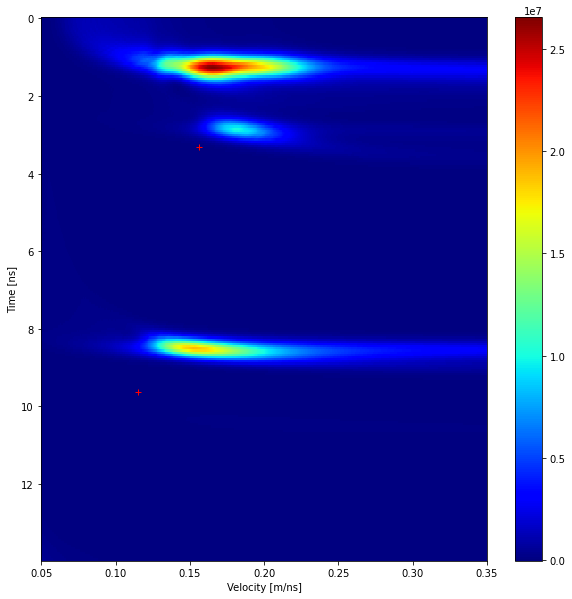

In [10]:
#NOOOO
cross_correlation_plot = cross_correlation.copy()
cross_correlation_plot[cross_correlation<np.quantile(cross_correlation, 0.90)] = 0
fig, ax = plt.subplots(figsize = (10, 10))
plot_1 = ax.pcolor(velocity*1e-9, res_t*1e9, cross_correlation, cmap='jet')
ax.plot(0.1560, 3.3053, 'r+')
ax.plot(0.1151, 9.6359, 'r+')
#ax.plot(2.8572e-9, 0.1825e9, 'r+')
ax.invert_yaxis()
ax.set_xlabel("Velocity [m/ns]")
ax.set_ylabel("Time [ns]")
fig.colorbar(plot_1, ax=ax)

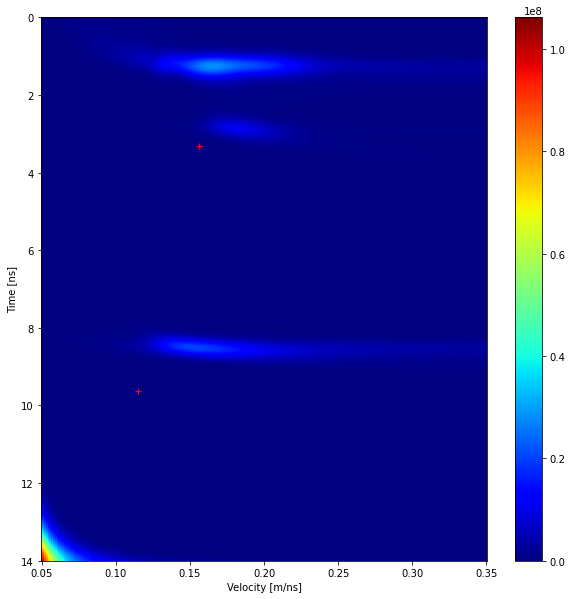

In [8]:
#NOOOO
cross_correlation_plot = cross_correlation.copy()
cross_correlation_plot[cross_correlation<np.quantile(cross_correlation, 0.90)] = 0
fig, ax = plt.subplots(figsize = (10, 10))
plot_1 = ax.pcolor(velocity*1e-9, res_t*1e9, cross_correlation, cmap='jet')
ax.plot(0.1560, 3.3053, 'r+')
ax.plot(0.1151, 9.6359, 'r+')
#ax.plot(2.8572e-9, 0.1825e9, 'r+')
ax.invert_yaxis()
ax.set_xlabel("Velocity [m/ns]")
ax.set_ylabel("Time [ns]")
fig.colorbar(plot_1, ax=ax)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x00000214B40CC1C0>


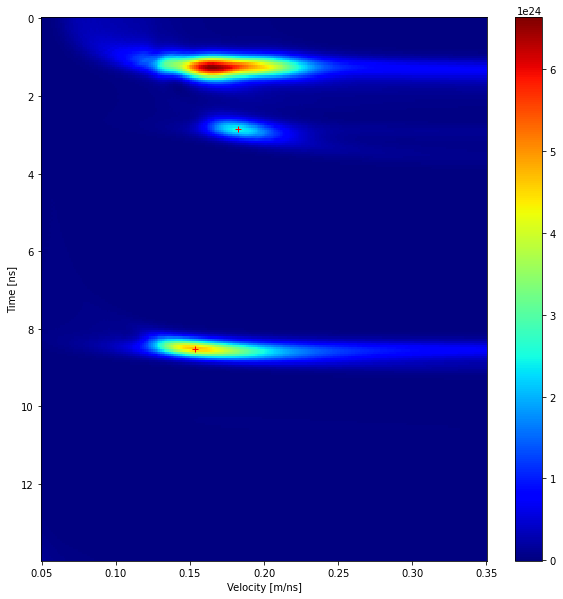

In [16]:
cross_correlation_plot = cross_correlation.copy()
cross_correlation_plot[cross_correlation<cross_correlation.mean()+ 0.2*cross_correlation.std()] = 0
fig, ax = plt.subplots(figsize = (10, 10))
plot_1 = ax.pcolor(velocity*1e-9, res_t*1e9, cross_correlation, cmap='jet')
ax.plot(0.1833, 2.8572, 'r+')
ax.plot(0.1536, 8.5155, 'r+')
#ax.plot(2.8572e-9, 0.1825e9, 'r+')
ax.invert_yaxis()
ax.set_xlabel("Velocity [m/ns]")
ax.set_ylabel("Time [ns]")
fig.colorbar(plot_1, ax=ax)



DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\leone\\anaconda3\\envs\\Demining\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\leone\\anaconda3\\envs\\Demining\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\leone\\anaconda3\\envs\

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\leone\\anaconda3\\envs\\Demining\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\leone\\anaconda3\\envs\\Demining\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\leone\\anaconda3\\envs\\Demining\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
DEBUG

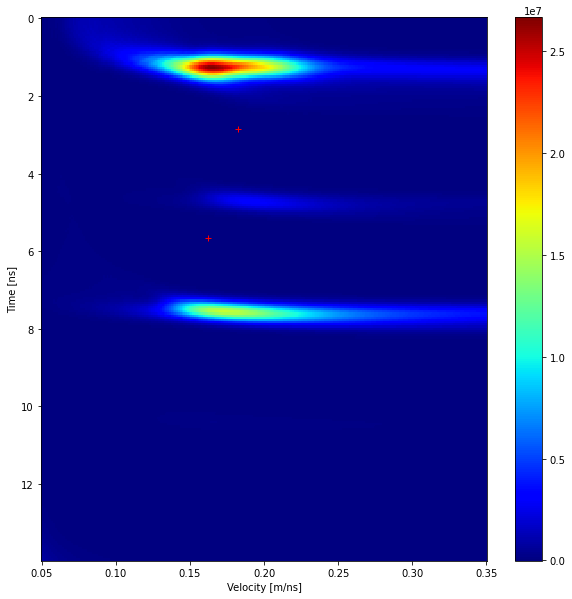

In [16]:
cross_correlation_plot = cross_correlation.copy()
cross_correlation_plot[cross_correlation<cross_correlation.mean()+ 0.2*cross_correlation.std()] = 0
fig, ax = plt.subplots(figsize = (10, 10))
plot_1 = ax.pcolor(velocity*1e-9, res_t*1e9, cross_correlation, cmap='jet')
ax.plot(0.1825, 2.8572, 'r+')
ax.plot(0.1620, 5.6583, 'r+')
ax.invert_yaxis()
ax.set_xlabel("Velocity [m/ns]")
ax.set_ylabel("Time [ns]")
fig.colorbar(plot_1, ax=ax)

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x000001E0030483D0>


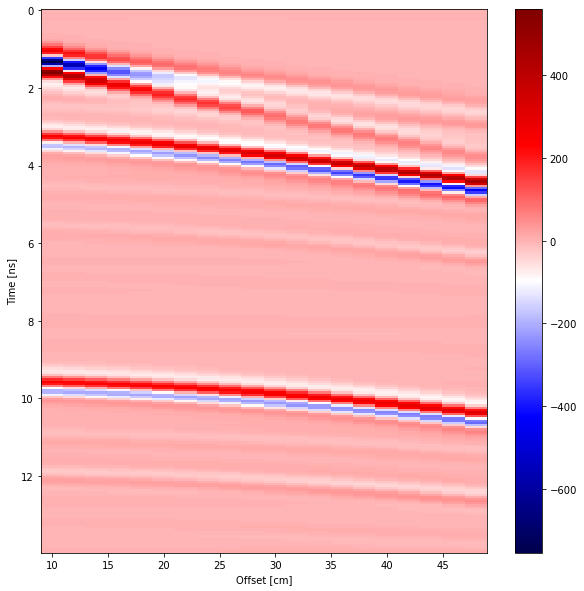

In [73]:
fig, ax = plt.subplots(figsize = (10, 10))
plot_1 = ax.pcolor(offset*1e2, res_t*1e9, res_c_scan.swapaxes(0, 1), cmap='seismic')
ax.invert_yaxis()
ax.set_xlabel("Offset [cm]")
ax.set_ylabel("Time [ns]")
fig.colorbar(plot_1, ax=ax)

In [96]:
max_idx=np.where(cross_correlation >= cross_correlation.mean()+cross_correlation.std())


In [86]:
t_sel = t[max_idx[0]]
v_sel = velocity[max_idx[1]]

2.169565217391304

In [97]:

X = np.column_stack((max_idx[0], max_idx[1]))
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

C:\Users\leone\anaconda3\envs\Demining\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [113]:
first_cluster_idx = X[kmeans.labels_ == 0]
second_cluster_idx = X[kmeans.labels_ == 1]

first_max_idx=np.where(cross_correlation[first_cluster_idx[:,0], first_cluster_idx[:,1]] == cross_correlation[first_cluster_idx[:,0], first_cluster_idx[:,1]].max())
print(first_max_idx)

(array([20, 21, 22, 23, 24, 25, 26, 27], dtype=int64),)


In [111]:
cross_correlation[first_cluster_idx[:,0], first_cluster_idx[:,1]]


array([0.00055908, 0.00090511, 0.00090511, 0.00090511, 0.00090511,
       0.00090511, 0.00090511, 0.00090511, 0.00090511, 0.00094784,
       0.00173607, 0.00173607, 0.00173607, 0.00173607, 0.00173607,
       0.00173607, 0.00173607, 0.00173607, 0.00042029, 0.00131169,
       0.00206948, 0.00206948, 0.00206948, 0.00206948, 0.00206948,
       0.00206948, 0.00206948, 0.00206948, 0.00102406, 0.00159694,
       0.00159694, 0.00159694, 0.00159694, 0.00159694, 0.00159694,
       0.00159694, 0.00159694, 0.00053272, 0.00080702, 0.00080702,
       0.00080702, 0.00080702, 0.00080702, 0.00080702, 0.00080702,
       0.00080702])

In [181]:
1.5126*0.16/2

0.121008

In [165]:
2*0.2/(3e8/np.sqrt(2))

1.885618083164127e-09

In [167]:
(3e8/np.sqrt(2))*1e-9

0.21213203435596426